In [ ]:
import IPython
from torchfsdd import TorchFSDDGenerator, TrimSilence
from torchaudio.transforms import MFCC, TimeMasking, FrequencyMasking
from torchvision.transforms import Compose

from matplotlib import pyplot as plt

SAMPLING_RATE = 8e3  # 8kHz
N_MFCC_CHANNELS = 13  # Number of MFCC channels

# chop off silence from the beginning and end of the audio
trimmer = TrimSilence(threshold=1e-6)

mfcc = MFCC(sample_rate=SAMPLING_RATE, n_mfcc=N_MFCC_CHANNELS)

time_masking = TimeMasking(time_mask_param=2)
freq_masking = FrequencyMasking(freq_mask_param=2)

# Create a transformation pipeline to apply to the recordings
transforms = Compose([
    trimmer,
    mfcc,
])

# Fetch the latest version of FSDD and initialize a generator with those files
fsdd = TorchFSDDGenerator(version='master', transforms=None)

# Create a Torch dataset for the entire dataset from the generator
# full_set = fsdd.full()
# Create two Torch datasets for a train-test split from the generator
# train_set, test_set = fsdd.train_test_split(test_size=0.1)
# Create three Torch datasets for a train-validation-test split from the generator
train_set, val_set, test_set = fsdd.train_val_test_split(test_size=0.15, val_size=0.15)

In [2]:
data = test_set[1]


In [3]:
sample, label = data

IPython.display.Audio(sample.numpy(), rate=SAMPLING_RATE)

In [4]:


trimmed_sample = trimmer(sample)

#### Trimming silences
chunks of signal lower than threshold at the beginning and end are cut off

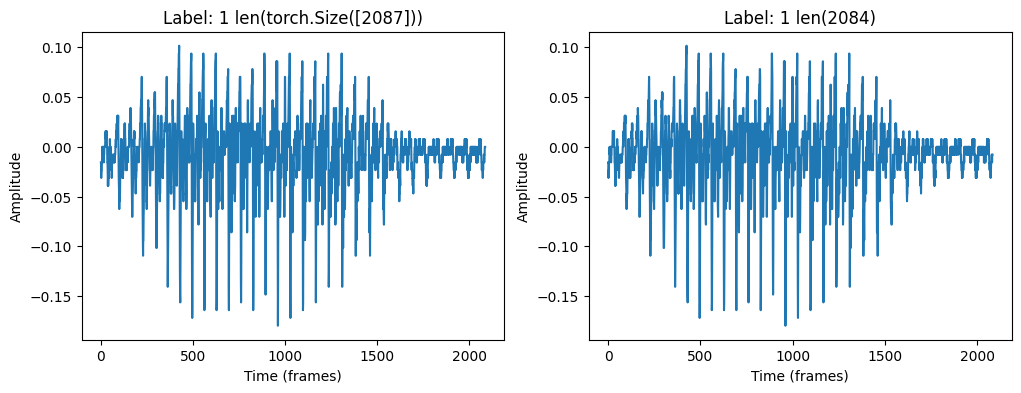

In [31]:

f, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.plot(sample,)
ax.set_title(f'Label: {label} len({sample.shape})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Amplitude')
ax = axs[1]
ax.plot(trimmed_sample,)
ax.set_title(f'Label: {label} len({len(trimmed_sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Amplitude')
plt.show()

#### Mel Frequency Cepstral Coefficients (MFCC)
Shape of spectral envelope

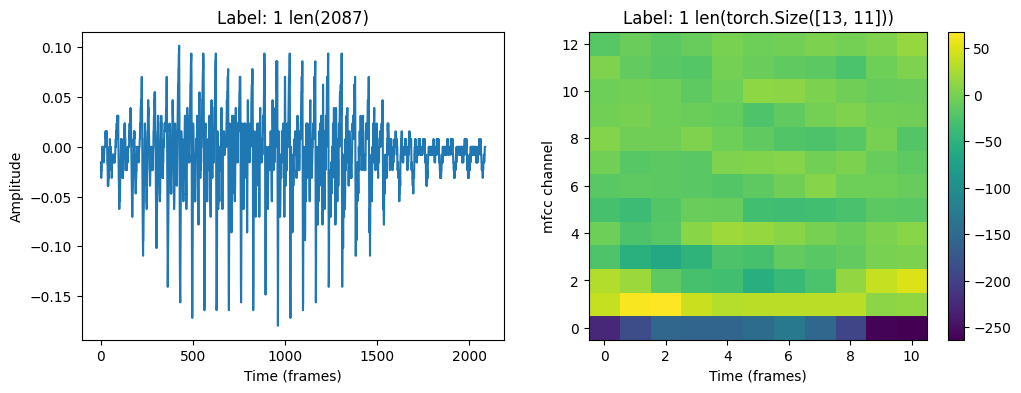

In [32]:
mfcc_sample = mfcc(sample)
f, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.plot(sample)
ax.set_title(f'Label: {label} len({len(sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Amplitude')
ax = axs[1]
im = ax.imshow(mfcc_sample, aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'Label: {label} len({mfcc_sample.shape})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
plt.show()

#### Augmentation
Masking in a "channel" or a frame to enhance robustness

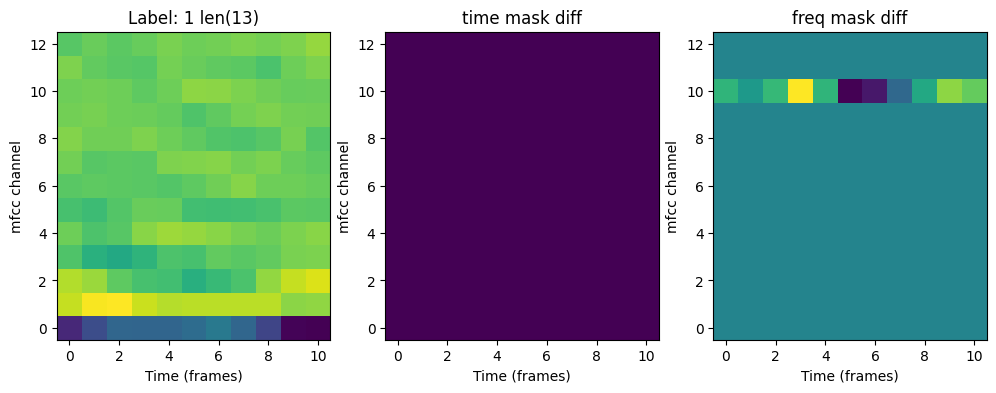

In [7]:
time_masked = time_masking(mfcc_sample)
freq_masked = freq_masking(mfcc_sample)

f, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.imshow(mfcc_sample, aspect='auto', origin='lower')
ax.set_title(f'Label: {label} len({len(mfcc_sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
ax = axs[1]
ax.imshow(time_masked - mfcc_sample, aspect='auto', origin='lower')
ax.set_title(f'time mask diff')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
ax = axs[2]
ax.imshow(freq_masked - mfcc_sample, aspect='auto', origin='lower')
ax.set_title(f'freq mask diff')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
plt.show()


#### Normalize std
center data to zero mean and unit variance

tensor([ 8.6698e-08, -6.9087e-08,  3.2512e-08,  1.0837e-08,  2.1674e-08,
         2.3300e-07,  3.2512e-08,  1.0837e-08,  4.3349e-08,  2.7093e-08,
         1.6256e-08,  5.4186e-08,  2.7093e-08])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])
tensor([ 9.5367e-07, -7.5996e-07,  3.5763e-07,  1.1921e-07,  2.3842e-07,
         2.5630e-06,  3.5763e-07,  1.1921e-07,  4.7684e-07,  2.9802e-07,
         1.7881e-07,  5.9605e-07,  2.9802e-07])


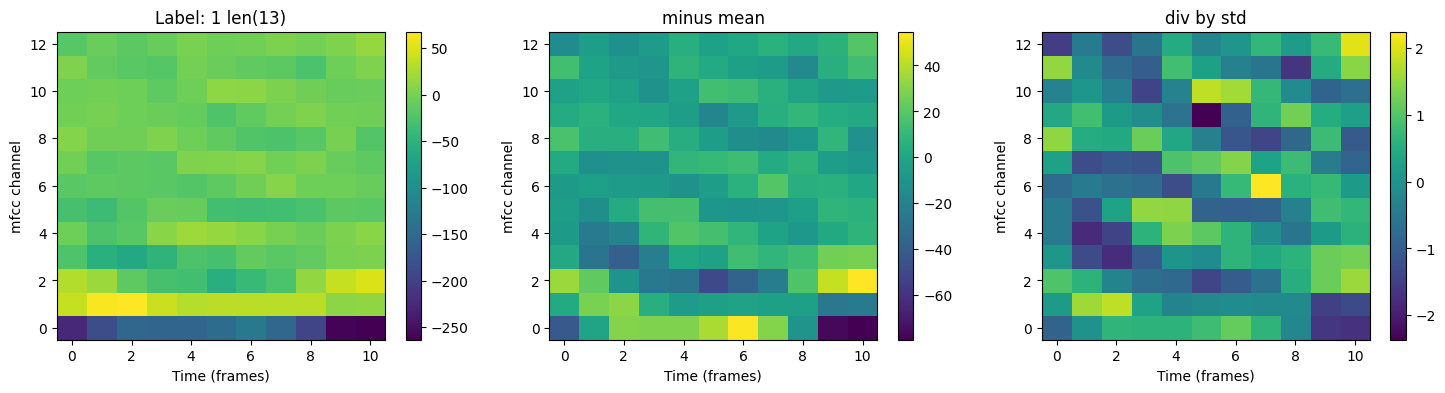

In [8]:
mean = mfcc_sample.mean(dim=1)
std = mfcc_sample.std(dim=1)
normalized_mfcc = (mfcc_sample - mean[:, None]) / (std[:, None] + 2e-30)
print(normalized_mfcc.mean(dim=1))
print(normalized_mfcc.var(dim=1))
print(normalized_mfcc.sum(dim=1))
f, axs = plt.subplots(1, 3, figsize=(18, 4))
ax = axs[0]
im = ax.imshow(mfcc_sample, aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'Label: {label} len({len(mfcc_sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')

ax = axs[1]
im = ax.imshow(mfcc_sample - mean[:, None], aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'minus mean')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')

ax = axs[2]
im = ax.imshow(normalized_mfcc, aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'div by std')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
plt.show()


### stats

In [14]:
import numpy as np


In [23]:

transformed_train = [transforms(x[0]) for x in train_set]


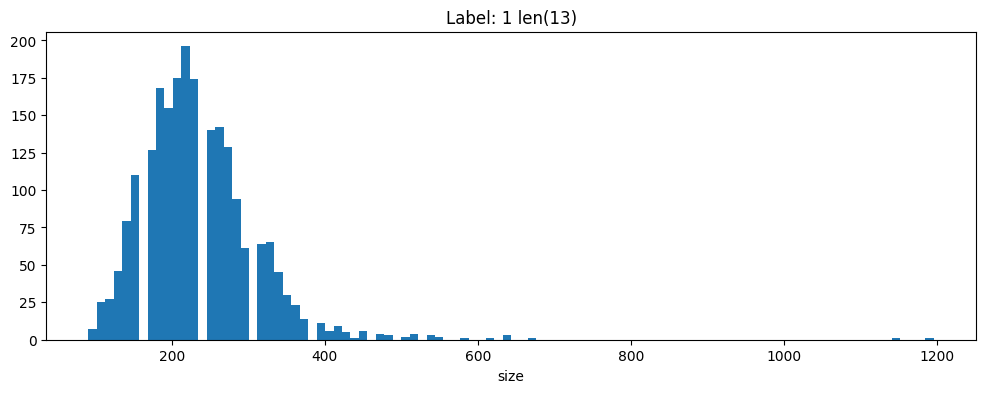

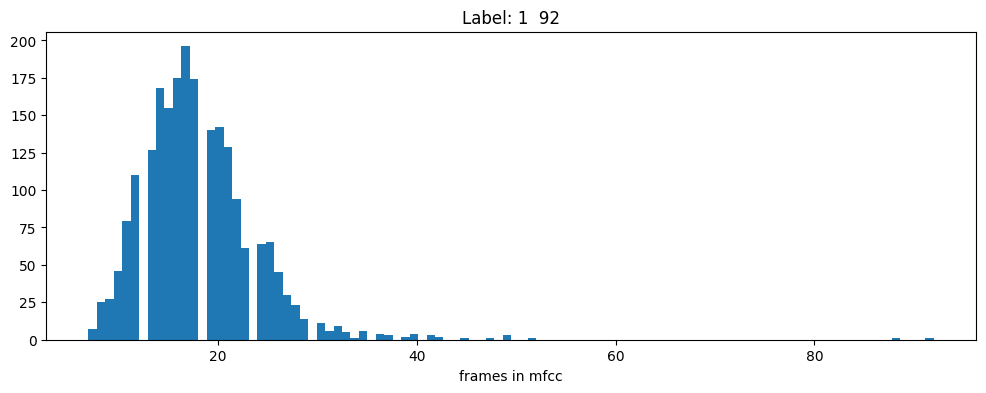

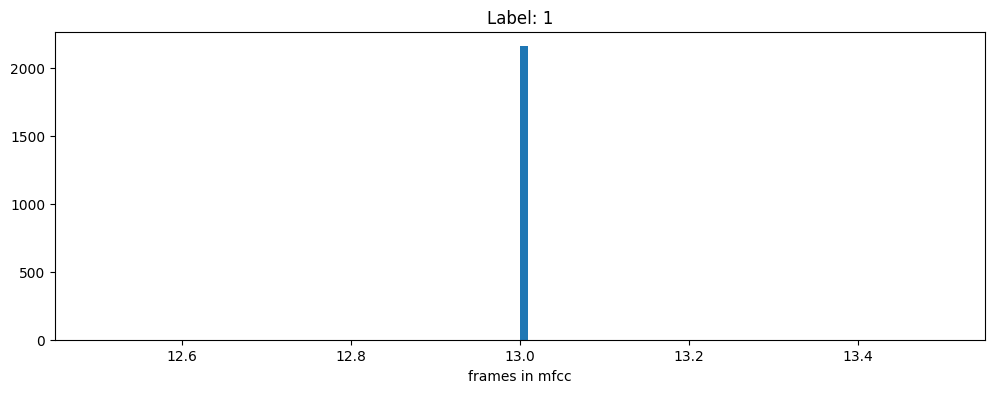

In [29]:
sizes = np.asarray([x.numel() for x in transformed_train])


f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(sizes, bins=100)
ax.set_title(f'Label: {label} len({len(mfcc_sample)})')
ax.set_xlabel("size")


widths = np.asarray([x.shape[1] for x in transformed_train])

f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(widths, bins=100)
ax.set_title(f'Label: {label}  {widths.max()}')
ax.set_xlabel("frames in mfcc")

heights = np.asarray([x.shape[0] for x in transformed_train])

f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(heights, bins=100)
ax.set_title(f'Label: {label}')
ax.set_xlabel("frames in mfcc")

plt.show()

In [25]:
labels = np.asarray([x[1] for x in train_set])

In [26]:
indices_per_class = {class_id: np.where(labels == class_id)[0] for class_id in range(10)}